# Implementation of matrix square root and matrix power

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np


from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.platform import tf_logging
from tensorflow.python.training import optimizer
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import linalg_ops
from tensorflow.python.ops import math_ops



def matrix_square_root(mat_a, mat_a_size, iter_count=100, ridge_epsilon=1e-4):
    """Iterative method to get matrix square root.

    Stable iterations for the matrix square root, Nicholas J. Higham

    Page 231, Eq 2.6b
    http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.6.8799&rep=rep1&type=pdf

    Args:
        mat_a: the symmetric PSD matrix whose matrix square root be computed
        mat_a_size: size of mat_a.
        iter_count: Maximum number of iterations.
        ridge_epsilon: Ridge epsilon added to make the matrix positive definite.

    Returns:
        mat_a^0.5
    """

    def _iter_condition(i, unused_mat_y, unused_old_mat_y, unused_mat_z,
                      unused_old_mat_z, err, old_err):
        # This method require that we check for divergence every step.
        return math_ops.logical_and(i < iter_count, err < old_err)

    def _iter_body(i, mat_y, unused_old_mat_y, mat_z, unused_old_mat_z, err,
                 unused_old_err):
        current_iterate = 0.5 * (3.0 * identity - math_ops.matmul(mat_z, mat_y))
        current_mat_y = math_ops.matmul(mat_y, current_iterate)
        current_mat_z = math_ops.matmul(current_iterate, mat_z)
        # Compute the error in approximation.
        mat_sqrt_a = current_mat_y * math_ops.sqrt(norm)
        mat_a_approx = math_ops.matmul(mat_sqrt_a, mat_sqrt_a)
        residual = mat_a - mat_a_approx
        current_err = math_ops.sqrt(math_ops.reduce_sum(residual * residual)) / norm
        return i + 1, current_mat_y, mat_y, current_mat_z, mat_z, current_err, err

    identity = linalg_ops.eye(math_ops.cast(mat_a_size, dtypes.int32))
    mat_a = mat_a + ridge_epsilon * identity
    norm = math_ops.sqrt(math_ops.reduce_sum(mat_a * mat_a))
    mat_init_y = mat_a / norm
    mat_init_z = identity
    init_err = norm

    _, _, prev_mat_y, _, _, _, _ = control_flow_ops.while_loop(
      _iter_condition, _iter_body, [
          0, mat_init_y, mat_init_y, mat_init_z, mat_init_z, init_err,
          init_err + 1.0
      ])
    return prev_mat_y * math_ops.sqrt(norm)


def matrix_inverse_pth_root(mat_g,
                            mat_g_size,
                            alpha,
                            iter_count=100,
                            epsilon=1e-6,
                            ridge_epsilon=1e-6):
    """Computes mat_g^alpha, where alpha = -1/p, p a positive integer.

    We use an iterative Schur-Newton method from equation 3.2 on page 9 of:

    A Schur-Newton Method for the Matrix p-th Root and its Inverse
    by Chun-Hua Guo and Nicholas J. Higham
    SIAM Journal on Matrix Analysis and Applications,
    2006, Vol. 28, No. 3 : pp. 788-804
    https://pdfs.semanticscholar.org/0abe/7f77433cf5908bfe2b79aa91af881da83858.pdf

    Args:
        mat_g: the symmetric PSD matrix whose power it to be computed
        mat_g_size: size of mat_g.
        alpha: exponent, must be -1/p for p a positive integer.
        iter_count: Maximum number of iterations.
        epsilon: accuracy indicator, useful for early termination.
        ridge_epsilon: Ridge epsilon added to make the matrix positive definite.

    Returns:
        mat_g^alpha
    """

    identity = linalg_ops.eye(math_ops.cast(mat_g_size, dtypes.int32))

    def mat_power(mat_m, p):
        """Computes mat_m^p, for p a positive integer.

        Power p is known at graph compile time, so no need for loop and cond.
        Args:
            mat_m: a square matrix
            p: a positive integer

        Returns:
          mat_m^p
        """
        assert p == int(p) and p > 0
        power = None
        while p > 0:
            if p % 2 == 1:
                power = math_ops.matmul(mat_m, power) if power is not None else mat_m
            p //= 2
            mat_m = math_ops.matmul(mat_m, mat_m)
        return power

    def _iter_condition(i, mat_m, _):
        return math_ops.logical_and(
            i < iter_count,
            math_ops.reduce_max(math_ops.abs(mat_m - identity)) > epsilon)

    def _iter_body(i, mat_m, mat_x):
        mat_m_i = (1 - alpha) * identity + alpha * mat_m
        return (i + 1, math_ops.matmul(mat_power(mat_m_i, -1.0 / alpha), mat_m),
            math_ops.matmul(mat_x, mat_m_i))

    if mat_g_size == 1:
        mat_h = math_ops.pow(mat_g + ridge_epsilon, alpha)
    else:
        damped_mat_g = mat_g + ridge_epsilon * identity
        z = (1 - 1 / alpha) / (2 * linalg_ops.norm(damped_mat_g))
        # The best value for z is
        # (1 - 1/alpha) * (c_max^{-alpha} - c_min^{-alpha}) /
        #                 (c_max^{1-alpha} - c_min^{1-alpha})
        # where c_max and c_min are the largest and smallest singular values of
        # damped_mat_g.
        # The above estimate assumes that c_max > c_min * 2^p. (p = -1/alpha)
        # Can replace above line by the one below, but it is less accurate,
        # hence needs more iterations to converge.
        # z = (1 - 1/alpha) / math_ops.trace(damped_mat_g)
        # If we want the method to always converge, use z = 1 / norm(damped_mat_g)
        # or z = 1 / math_ops.trace(damped_mat_g), but these can result in many
        # extra iterations.
        _, _, mat_h = control_flow_ops.while_loop(
            _iter_condition, _iter_body,
            [0, damped_mat_g * z, identity * math_ops.pow(z, -alpha)])
    return mat_h

In [37]:
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


In [38]:
print(np.__version__)

1.17.4


# Class Shampoo

In [2]:
"""The Shampoo Optimizer.

For details, see https://arxiv.org/abs/1802.09568
"""
def GetParam(var, timestep):
    if callable(var):
        return var(timestep)
    else:
        return var


class ShampooOptimizer(optimizer.Optimizer):
    """The Shampoo Optimizer

    Variant of Adagrad using one preconditioner matrix per variable dimension.
    For details, see https://arxiv.org/abs/1802.09568

    gbar is time-weighted accumulated gradient:
    gbar[t] = gbar_decay[t] * gbar[t-1] + gbar_weight[t] * g[t]

    mat_gbar is time-weighted accumulated gradient square:
    mat_gbar_j[t] = mat_gbar_decay[t] * mat_gbar_j[t-1]
                  + mat_gbar_weight[t] * gg_j[t]
    where if g[t] = g_abcd then gg_a[t] = g_abcd g_a'bcd (Einstein notation)

    Update rule:
    w[t+1] = w[t] - learning_rate[t] * Prod_j mat_gbar_j[t]^(-alpha/n) gbar[t]
    Again, mat_gbar_j[t]^(-alpha) gbar[t] is a tensor contraction along the
    j'th dimension of gbar[t] with the first dimension of
    mat_gbar_j[t]^(-alpha/n), where alpha is a hyperparameter,
    and n = rank of the variable.
    Prod_j represents doing this contraction for all j in 0..n-1.

    Typically learning_rate is constant, but could be time dependent by passing
    a lambda function that depends on step.
    """

    def __init__(self,
               global_step=0,
               max_matrix_size=768,
               gbar_decay=0.0,
               gbar_weight=1.0,
               mat_gbar_decay=1.0,
               mat_gbar_weight=1.0,
               learning_rate=1.0,
               svd_interval=1,
               precond_update_interval=1,
               epsilon=1e-4,
               alpha=0.5,
               use_iterative_root=False,
               use_locking=False,
               name="Shampoo"):
        """Default values of the various hyper-parameters.

        gbar_decay, gbar_weight etc. can be a float or a time varying parameter.
        For time-varying parameters use e.g. "lambda T: T / (T + 1.0)"
        where the expression in the lambda is a tensorflow expression

        Args:
          global_step: tensorflow variable indicating the step.
          max_matrix_size: We do not perform SVD for matrices larger than this.
          gbar_decay:
          gbar_weight:  Used to update gbar:
                gbar[t] = gbar_decay[t] * gbar[t-1] + gbar_weight[t] * g[t]
          mat_gbar_decay:
          mat_gbar_weight:  Used to update mat_gbar:
               mat_gbar_j[t] = mat_gbar_decay[t] * mat_gbar_j[t-1]
                               + mat_gbar_weight[t] * gg_j[t]
          learning_rate: Similar to SGD
          svd_interval: We should do SVD after this many steps. Default = 1, i.e.
                        every step. Usually 20 leads to no loss of accuracy, and
                        50 or 100 is also OK. May also want more often early,
                        and less often later - set in caller as for example:
                        "svd_interval = lambda(T): tf.cond(
                            T < 2000, lambda: 20.0, lambda: 1000.0)"
          precond_update_interval: We should update the preconditioners after
                                   this many steps. Default = 1. Usually less than
                                   svd_interval.
          epsilon:  epsilon * I_n is added to each mat_gbar_j for stability for
                    non-diagonal version of shampoo.
          alpha:  total power of the preconditioners.
          use_iterative_root: should the optimizer use SVD (faster) or the
                              iterative root method (for TPU) for finding the
                              roots of PSD matrices.
          use_locking:
          name: name of optimizer.
        """

        super(ShampooOptimizer, self).__init__(use_locking, name)

        self._global_step = math_ops.cast(global_step, dtypes.float32)
        self._max_matrix_size = max_matrix_size
        self._gbar_decay = gbar_decay
        self._gbar_weight = gbar_weight
        self._mat_gbar_decay = mat_gbar_decay
        self._mat_gbar_weight = mat_gbar_weight
        self._learning_rate = learning_rate
        self._svd_interval = svd_interval
        self._precond_update_interval = precond_update_interval
        self._epsilon = epsilon
        self._alpha = alpha
        self._use_iterative_root = use_iterative_root
        self._name = name

    def _create_slots(self, var_list):
        for v in var_list:
            with ops.colocate_with(v):
                _ = self._zeros_slot(v, "gbar", self._name)
                shape = np.array(v.get_shape())
                for i, d in enumerate(shape):
                    d_tensor = ops.convert_to_tensor(d)
                    if d <= self._max_matrix_size:
                        mat_g_init = array_ops.zeros_like(linalg_ops.eye(d_tensor))
                        if self._svd_interval > 1:
                            _ = self._get_or_make_slot(v, linalg_ops.eye(d_tensor),
                                         "H_" + str(i), self._name)
                    else:
                        mat_g_init = array_ops.zeros([d_tensor])

                    _ = self._get_or_make_slot(v, mat_g_init, "Gbar_" + str(i),
                                     self._name)

    def _resource_apply_dense(self, grad, var):
        return self._apply_dense(grad, var)

    def _apply_dense(self, grad, var):
        return self._apply_gradient(grad, var)

    def _resource_apply_sparse(self, grad_values, var, grad_indices):
        return self._apply_sparse_shared(grad_values, grad_indices, var)

    def _apply_sparse(self, grad, var):
        return self._apply_sparse_shared(grad.values, grad.indices, var)

    def _apply_sparse_shared(self, grad_values, grad_indices, var):
        if var.get_shape()[0] <= self._max_matrix_size or self._gbar_decay != 0.0:
            # The dimension is small enough, we can make the variable dense and
            # do a dense update
            dense_grad = array_ops.scatter_nd(
            array_ops.expand_dims(grad_indices, axis=1), grad_values,
            array_ops.shape(var, out_type=grad_indices.dtype))
            return self._apply_gradient(dense_grad, var)
    
        return self._apply_gradient(grad_values, var, grad_indices)

    def _weighted_average(self, var, weight, weight_t, rest):
        """Computes exponential weighted average: var = weight_t * var + rest.

        Important to ensure that var does not occur in rest, otherwise
        we can get race conditions in a distributed setting.

        Args:
          var: variable to be updated
          weight: parameter to be checked. If it is a constant, we can optimize.
          weight_t: current value of parameter, used for weighting
          rest: the remaining tensor to be added

        Returns:
          updated variable.
        """
        if weight == 0.0:
            return rest       # no need to update var, we will never use it.
        
        if weight == 1.0:   # common case
            return state_ops.assign_add(var, rest)
        # The op below can cause race conditions in a distributed setting,
        # since computing weight_t * var + rest can take some time, during
        # which var may be set by another worker. To prevent this, it should
        # be implemented as a C++ op.
        return var.assign_add((weight_t - 1) * var + rest)

    def _update_mat_g(self, mat_g, grad, axes, mat_gbar_decay,
                    mat_gbar_weight, i):
        """Updates the cumulative outer products of the gradients.

        Args:
          mat_g: the matrix to be updated
          grad: the gradient of the variable
          axes: a list of k-1 integers 0 to k-1, except i
          mat_gbar_decay: constant for weighted average:
              mat_g = mat_g * decay + grad * weight
          mat_gbar_weight: constant for weighted average
          i: index of dimension to be updated.

        Returns:
          updated mat_g = mat_g * mat_gbar_decay + grad_outer * mat_gbar_weight

        In Einstein notation if i = 0: grad_outer_aa'= g_abcd g_a'bcd
        thus grad_outer is a matrix d_i x d_i, where d_i is the size of the
        i'th dimension of g.
        Alternate view: If mat_i(grad) is the flattening of grad to a
        d_i x (d_1d_2...d_{i-1}d_{i+1}...d_k) matrix, then
             grad_outer = mat_i(grad) mat_i(grad).transpose
        """
        grad_outer = math_ops.tensordot(grad, grad, axes=(axes, axes),
                                        name="grad_outer_" + str(i))
        return self._weighted_average(mat_g, self._mat_gbar_decay, mat_gbar_decay,
                                      mat_gbar_weight * grad_outer)

    def _compute_power_svd(self, var, mat_g, mat_g_size, alpha, mat_h_slot_name):
        """Computes mat_h = mat_g^alpha using svd. mat_g is a symmetric PSD matrix.

        Args:
          var: the variable we are updating.
          mat_g: the symmetric PSD matrix whose power it to be computed
          mat_g_size: size of mat_g
          alpha: a real number
          mat_h_slot_name: name of slot to store the power, if needed.

        Returns:
          mat_h = mat_g^alpha

        Stores mat_h in the appropriate slot, if it exists.
        Note that mat_g is PSD. So we could use linalg_ops.self_adjoint_eig.
        """
        if mat_g_size == 1:
            mat_h = math_ops.pow(mat_g + self._epsilon, alpha)
        else:
            damping = self._epsilon * linalg_ops.eye(
              math_ops.cast(mat_g_size, dtypes.int32))
            diag_d, mat_u, mat_v = linalg_ops.svd(mat_g + damping, full_matrices=True)
            mat_h = math_ops.matmul(
              mat_v * math_ops.pow(math_ops.maximum(diag_d, self._epsilon), alpha),
              array_ops.transpose(mat_u))
        if mat_h_slot_name is not None:
            return state_ops.assign(self.get_slot(var, mat_h_slot_name), mat_h)
        return mat_h

    def _compute_power_iter(self, var, mat_g, mat_g_size, alpha, mat_h_slot_name,
                          iter_count=100, epsilon=1e-6):
        """Computes mat_g^alpha, where alpha = -1/p, p a positive integer."""

        mat_g_sqrt = matrix_functions.matrix_square_root(mat_g, mat_g_size,
                                                         iter_count, self._epsilon)
        mat_h = matrix_functions.matrix_inverse_pth_root(
            mat_g_sqrt,
            mat_g_size,
            2 * alpha,
            iter_count,
            epsilon,
            ridge_epsilon=0.0)

        if mat_h_slot_name is not None:
            return state_ops.assign(self.get_slot(var, mat_h_slot_name), mat_h)
        return mat_h

    def _compute_power(self, var, mat_g, mat_g_size, alpha, mat_h_slot_name=None):
        """Just a switch between the iterative power vs svd."""
        with ops.name_scope("matrix_iterative_power"):
            if self._use_iterative_root:
                return self._compute_power_iter(var, mat_g, mat_g_size, alpha,
                                            mat_h_slot_name)
            else:
                return self._compute_power_svd(var, mat_g, mat_g_size, alpha,
                                           mat_h_slot_name)

    def _apply_gradient(self, grad, var, indices=None):
        """The main function to update a variable.

        Args:
          grad: A Tensor containing gradient to apply.
          var: A Tensor containing the variable to update.
          indices: An array of integers, for sparse update.

        Returns:
          Updated variable var = var - learning_rate * preconditioner * grad

        If the gradient is dense, var and grad have the same shape.
        If the update is sparse, then the first dimension of the gradient and var
        may differ, others are all the same. In this case the indices array
        provides the set of indices of the variable which are to be updated with
        each row of the gradient.
        """
        global_step = self._global_step + 1

        # Update accumulated weighted average of gradients
        gbar = self.get_slot(var, "gbar")
        gbar_decay_t = GetParam(self._gbar_decay, global_step)
        gbar_weight_t = GetParam(self._gbar_weight, global_step)
        if indices is not None:
          # Note - the sparse update is not easily implemented, since the
          # algorithm needs all indices of gbar to be updated
          # if mat_gbar_decay != 1 or mat_gbar_decay != 0.
          # One way to make mat_gbar_decay = 1 is by rescaling.
          # If we want the update:
          #         G_{t+1} = a_{t+1} G_t + b_{t+1} w_t
          # define:
          #         r_{t+1} = a_{t+1} * r_t
          #         h_t = G_t / r_t
          # Then:
          #         h_{t+1} = h_t + (b_{t+1} / r_{t+1}) * w_t
          # So we get the mat_gbar_decay = 1 as desired.
          # We can implement this in a future version as needed.
          # However we still need gbar_decay = 0, otherwise all indices
          # of the variable will need to be updated.
            if self._gbar_decay != 0.0:
                tf_logging.warning("Not applying momentum for variable: %s" % var.name)
            gbar_updated = grad
        else:
            gbar_updated = self._weighted_average(gbar, self._gbar_decay,
                                                gbar_decay_t,
                                                gbar_weight_t * grad)

        # Update the preconditioners and compute the preconditioned gradient
        shape = var.get_shape()
        mat_g_list = []
        for i in range(len(shape)):
            mat_g_list.append(self.get_slot(var, "Gbar_" + str(i)))
        mat_gbar_decay_t = GetParam(self._mat_gbar_decay, global_step)
        mat_gbar_weight_t = GetParam(self._mat_gbar_weight, global_step)

        preconditioned_grad = gbar_updated
        v_rank = len(mat_g_list)
        neg_alpha = - GetParam(self._alpha, global_step) / v_rank
        svd_interval = GetParam(self._svd_interval, global_step)
        precond_update_interval = GetParam(self._precond_update_interval,
                                           global_step)
        for i, mat_g in enumerate(mat_g_list):
            # axes is the list of indices to reduce - everything but the current i.
            axes = list(range(i)) + list(range(i+1, v_rank))
            if shape[i] <= self._max_matrix_size:
                # If the tensor size is sufficiently small perform full Shampoo update
                # Note if precond_update_interval > 1 and mat_gbar_decay_t != 1, this
                # is not strictly correct. However we will use it for now, and
                # fix if needed. (G_1 = aG + bg ==> G_n = a^n G + (1+a+..+a^{n-1})bg)

                # pylint: disable=g-long-lambda,cell-var-from-loop
                mat_g_updated = control_flow_ops.cond(
                    math_ops.mod(global_step, precond_update_interval) < 1,
                    lambda: self._update_mat_g(mat_g, grad, axes, mat_gbar_decay_t,
                                           mat_gbar_weight_t * precond_update_interval, i), lambda: mat_g)

                #mat_g_updated = mat_g_updated / float(shape[i].value)
                mat_g_updated = mat_g_updated / float(shape[i])

                if self._svd_interval == 1:
                    mat_h = self._compute_power(var, mat_g_updated, shape[i], neg_alpha)
                else:
                    mat_h = control_flow_ops.cond(
                        math_ops.mod(global_step, svd_interval) < 1,
                        lambda: self._compute_power(var, mat_g_updated, shape[i],
                                              neg_alpha, "H_" + str(i)),
                        lambda: self.get_slot(var, "H_" + str(i)))

                # mat_h is a square matrix of size d_i x d_i
                # preconditioned_grad is a d_i x ... x d_n x d_0 x ... d_{i-1} tensor
                # After contraction with a d_i x d_i tensor
                # it becomes a d_{i+1} x ... x d_n x d_0 x ... d_i tensor
                # (the first dimension is contracted out, and the second dimension of
                # mat_h is appended).  After going through all the indices, it becomes
                # a d_0 x ... x d_n tensor again.
                preconditioned_grad = math_ops.tensordot(preconditioned_grad, mat_h,
                                                         axes=([0], [0]),
                                                         name="precond_" + str(i))
            else:
                # Tensor size is too large -- perform diagonal Shampoo update
                # Only normalize non-vector cases.
                if axes:
                    #normalizer = 1.0 if indices is not None else float(shape[i].value)
                    normalizer = 1.0 if indices is not None else float(shape[i])
                    grad_outer = math_ops.reduce_sum(grad * grad, axis=axes) / normalizer
                else:
                    grad_outer = grad * grad

                if i == 0 and indices is not None:
                    assert self._mat_gbar_decay == 1.0
                    mat_g_updated = state_ops.scatter_add(mat_g, indices,
                                                        mat_gbar_weight_t * grad_outer)
                    mat_g_updated_slice = array_ops.gather(mat_g_updated, indices)
                    mat_h = array_ops.where(
                      math_ops.greater(mat_g_updated_slice, 0),
                      math_ops.pow(mat_g_updated_slice, neg_alpha),
                      array_ops.zeros_like(mat_g_updated_slice))
                else:
                    mat_g_updated = self._weighted_average(mat_g,
                                                         self._mat_gbar_decay,
                                                         mat_gbar_decay_t,
                                                         mat_gbar_weight_t * grad_outer)
                    mat_h = array_ops.where(
                      math_ops.greater(mat_g_updated, 0),
                      math_ops.pow(mat_g_updated, neg_alpha),
                      array_ops.zeros_like(mat_g_updated))

                # Need to do the transpose to ensure that the tensor becomes
                # a d_{i+1} x ... x d_n x d_0 x ... d_i tensor as described above.
                preconditioned_grad = array_ops.transpose(
                    preconditioned_grad, perm=list(range(1, v_rank)) + [0]) * mat_h

        # Update the variable based on the Shampoo update
        learning_rate_t = GetParam(self._learning_rate, global_step)
        if indices is not None:
            var_updated = state_ops.scatter_add(
              var, indices, -learning_rate_t * preconditioned_grad)
        else:
            var_updated = state_ops.assign_sub(var,
                                             learning_rate_t * preconditioned_grad)
        return var_updated

# CIFAR-10

In [1]:
from tensorflow.keras import datasets, layers, models
import tensorflow as tf
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout
from keras.layers import AveragePooling2D, Input, Flatten, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model, Sequential
from keras.datasets import cifar10
from keras import backend
from keras.utils import np_utils
import numpy
from keras.datasets import cifar10
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

Using TensorFlow backend.


In [39]:
print(keras.__version__)

2.3.1


In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [3]:
train_images.shape

(50000, 32, 32, 3)

# Vizualization

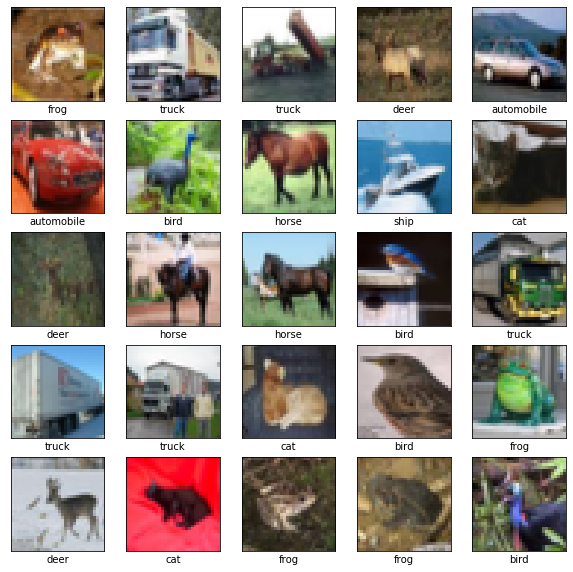

In [55]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [56]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = train_images / 255.0
test_images = test_images / 255.0

In [57]:
num_classes = test_labels.shape[1]

In [58]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
# Compile model
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [12]:
def loss(model, x, y):
    y_ = model(x)

    return loss_object(y_true=y, y_pred=y_)

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
        return loss_value, tape.gradient(loss_value, model.trainable_weights)

In [60]:
train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)

# Training loop

In [63]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = ShampooOptimizer(learning_rate=0.01)

shampoo_train_loss_results = []
shampoo_train_accuracy_results = []

epochs = 250
batch_size = 128

for epoch in range(epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    # Training loop - using batches of 128
    for i in range(train_images.shape[0] // batch_size):
        x = train_images[i:i+batch_size]
        y = train_labels[i:i+batch_size]
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Track progress
        epoch_loss_avg(loss_value)  # Add current batch loss
        # Compare predicted label to actual label
        epoch_accuracy(y, model(x))

        # End epoch
    shampoo_train_loss_results.append(epoch_loss_avg.result())
    shampoo_train_accuracy_results.append(epoch_accuracy.result())

    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.940, Accuracy: 53.990%
Epoch 001: Loss: 1.857, Accuracy: 60.988%
Epoch 002: Loss: 1.820, Accuracy: 64.503%
Epoch 003: Loss: 1.801, Accuracy: 65.931%
Epoch 004: Loss: 1.794, Accuracy: 66.404%
Epoch 005: Loss: 1.787, Accuracy: 66.925%
Epoch 006: Loss: 1.781, Accuracy: 67.460%
Epoch 007: Loss: 1.778, Accuracy: 67.704%
Epoch 008: Loss: 1.773, Accuracy: 68.113%
Epoch 009: Loss: 1.771, Accuracy: 68.257%
Epoch 010: Loss: 1.770, Accuracy: 68.281%
Epoch 011: Loss: 1.770, Accuracy: 68.281%
Epoch 012: Loss: 1.732, Accuracy: 72.694%
Epoch 013: Loss: 1.700, Accuracy: 76.064%
Epoch 014: Loss: 1.694, Accuracy: 76.500%
Epoch 015: Loss: 1.691, Accuracy: 76.689%
Epoch 016: Loss: 1.689, Accuracy: 76.765%
Epoch 017: Loss: 1.689, Accuracy: 76.773%
Epoch 018: Loss: 1.688, Accuracy: 76.773%
Epoch 019: Loss: 1.688, Accuracy: 76.773%
Epoch 020: Loss: 1.688, Accuracy: 76.777%
Epoch 021: Loss: 1.687, Accuracy: 76.823%
Epoch 022: Loss: 1.684, Accuracy: 77.133%
Epoch 023: Loss: 1.683, Accuracy: 

KeyboardInterrupt: 

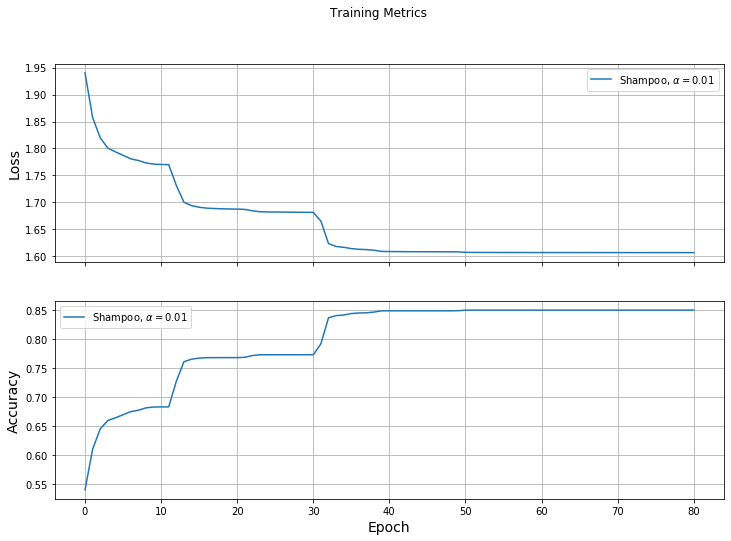

In [64]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(shampoo_train_loss_results, label = r"Shampoo, $\alpha = {0}$".format(0.01))
axes[0].grid()
axes[0].legend()

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(shampoo_train_accuracy_results, label = r"Shampoo, $\alpha = {0}$".format(0.01))
axes[1].grid()
axes[1].legend()
plt.show()

In [66]:
with open("shampoo_train_loss_results_alpha_0_01_cnn_cifar_10.txt", "w") as file:
    print(*shampoo_train_loss_results, file=file)
    
with open("shampoo_train_accuracy_results_alpha_0_01_cnn_cifar_10txt", "w") as file:
    print(*shampoo_train_accuracy_results, file=file)

# Training Adam

In [68]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

adam_train_loss_results = []
adam_train_accuracy_results = []

epochs = 250
batch_size = 128

for epoch in range(epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    # Training loop - using batches of 128
    for i in range(train_images.shape[0] // batch_size):
        x = train_images[i:i+batch_size]
        y = train_labels[i:i+batch_size]
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Track progress
        epoch_loss_avg(loss_value)  # Add current batch loss
        # Compare predicted label to actual label
        epoch_accuracy(y, model(x))

        # End epoch
    adam_train_loss_results.append(epoch_loss_avg.result())
    adam_train_accuracy_results.append(epoch_accuracy.result())

    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 2.047, Accuracy: 41.488%
Epoch 001: Loss: 1.904, Accuracy: 55.633%
Epoch 002: Loss: 1.792, Accuracy: 66.997%
Epoch 003: Loss: 1.705, Accuracy: 75.563%
Epoch 004: Loss: 1.631, Accuracy: 83.037%
Epoch 005: Loss: 1.605, Accuracy: 85.533%
Epoch 006: Loss: 1.596, Accuracy: 86.324%
Epoch 007: Loss: 1.587, Accuracy: 87.190%
Epoch 008: Loss: 1.577, Accuracy: 88.155%
Epoch 009: Loss: 1.575, Accuracy: 88.321%
Epoch 010: Loss: 1.572, Accuracy: 88.536%
Epoch 011: Loss: 1.572, Accuracy: 88.536%
Epoch 012: Loss: 1.572, Accuracy: 88.556%
Epoch 013: Loss: 1.563, Accuracy: 89.595%
Epoch 014: Loss: 1.556, Accuracy: 90.485%
Epoch 015: Loss: 1.552, Accuracy: 90.911%
Epoch 016: Loss: 1.539, Accuracy: 92.095%
Epoch 017: Loss: 1.538, Accuracy: 92.181%
Epoch 018: Loss: 1.535, Accuracy: 92.422%
Epoch 019: Loss: 1.535, Accuracy: 92.440%
Epoch 020: Loss: 1.532, Accuracy: 92.660%
Epoch 021: Loss: 1.531, Accuracy: 92.843%
Epoch 022: Loss: 1.529, Accuracy: 93.127%
Epoch 023: Loss: 1.528, Accuracy: 

KeyboardInterrupt: 

In [70]:
def plot_metric(optimizer_name, alpha):
    fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
    fig.suptitle('Training Metrics')

    axes[0].set_ylabel("Loss", fontsize=14)
    axes[0].plot(adam_train_loss_results, label = r"{0}, $\alpha = {1}$".format(optimizer_name, alpha))
    axes[0].grid()
    axes[0].legend()

    axes[1].set_ylabel("Accuracy", fontsize=14)
    axes[1].set_xlabel("Epoch", fontsize=14)
    axes[1].plot(adam_train_accuracy_results, label = r"{0}, $\alpha = {1}$".format(optimizer_name, alpha))
    axes[1].grid()
    axes[1].legend()
    plt.show()

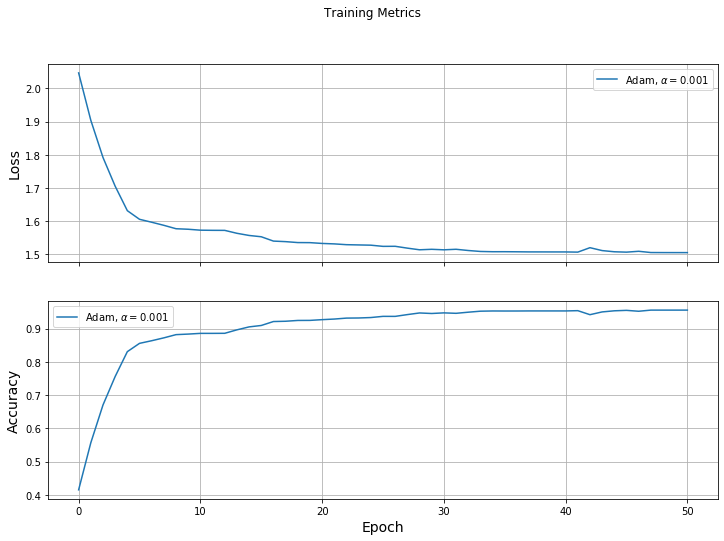

In [71]:
plot_metric("Adam", 0.001)

In [72]:
with open("adam_train_loss_results_alpha_0_01_cnn_cifar_10.txt", "w") as file:
    print(*adam_train_loss_results, file=file)
    
with open("adam_train_accuracy_results_alpha_0_01_cnn_cifar_10.txt", "w") as file:
    print(*adam_train_accuracy_results, file=file)

# We choose different learning rate

In [74]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = ShampooOptimizer(learning_rate=0.001)

shampoo_train_loss_results = []
shampoo_train_accuracy_results = []

epochs = 250
batch_size = 128

for epoch in range(epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    # Training loop - using batches of 128
    for i in range(train_images.shape[0] // batch_size):
        x = train_images[i:i+batch_size]
        y = train_labels[i:i+batch_size]
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Track progress
        epoch_loss_avg(loss_value)  # Add current batch loss
        # Compare predicted label to actual label
        epoch_accuracy(y, model(x))

        # End epoch
    shampoo_train_loss_results.append(epoch_loss_avg.result())
    shampoo_train_accuracy_results.append(epoch_accuracy.result())

    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 2.269, Accuracy: 20.180%
Epoch 001: Loss: 2.215, Accuracy: 25.853%
Epoch 002: Loss: 2.193, Accuracy: 27.869%
Epoch 003: Loss: 2.178, Accuracy: 29.307%


KeyboardInterrupt: 

In [75]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = ShampooOptimizer(learning_rate=0.1)

shampoo_train_loss_results = []
shampoo_train_accuracy_results = []

epochs = 250
batch_size = 128

for epoch in range(epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    # Training loop - using batches of 128
    for i in range(train_images.shape[0] // batch_size):
        x = train_images[i:i+batch_size]
        y = train_labels[i:i+batch_size]
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Track progress
        epoch_loss_avg(loss_value)  # Add current batch loss
        # Compare predicted label to actual label
        epoch_accuracy(y, model(x))

        # End epoch
    shampoo_train_loss_results.append(epoch_loss_avg.result())
    shampoo_train_accuracy_results.append(epoch_accuracy.result())

    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 2.330, Accuracy: 13.047%
Epoch 001: Loss: 2.331, Accuracy: 13.041%
Epoch 002: Loss: 2.331, Accuracy: 13.041%
Epoch 003: Loss: 2.136, Accuracy: 32.382%
Epoch 004: Loss: 1.855, Accuracy: 60.471%
Epoch 005: Loss: 1.747, Accuracy: 71.092%
Epoch 006: Loss: 1.707, Accuracy: 74.988%
Epoch 007: Loss: 1.662, Accuracy: 79.651%
Epoch 008: Loss: 1.632, Accuracy: 82.500%
Epoch 009: Loss: 1.626, Accuracy: 83.049%
Epoch 010: Loss: 1.624, Accuracy: 83.171%
Epoch 011: Loss: 1.621, Accuracy: 83.442%
Epoch 012: Loss: 1.619, Accuracy: 83.730%
Epoch 013: Loss: 1.617, Accuracy: 83.840%
Epoch 014: Loss: 1.617, Accuracy: 83.928%
Epoch 015: Loss: 1.616, Accuracy: 83.928%
Epoch 016: Loss: 1.616, Accuracy: 83.928%
Epoch 017: Loss: 1.616, Accuracy: 83.934%
Epoch 018: Loss: 1.616, Accuracy: 84.008%
Epoch 019: Loss: 1.615, Accuracy: 84.016%
Epoch 020: Loss: 1.612, Accuracy: 84.371%
Epoch 021: Loss: 1.610, Accuracy: 84.567%
Epoch 022: Loss: 1.609, Accuracy: 84.685%


KeyboardInterrupt: 

In [76]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = ShampooOptimizer(learning_rate=0.01, epsilon=1e-5)

shampoo_train_loss_results = []
shampoo_train_accuracy_results = []

epochs = 250
batch_size = 128

for epoch in range(epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    # Training loop - using batches of 128
    for i in range(train_images.shape[0] // batch_size):
        x = train_images[i:i+batch_size]
        y = train_labels[i:i+batch_size]
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Track progress
        epoch_loss_avg(loss_value)  # Add current batch loss
        # Compare predicted label to actual label
        epoch_accuracy(y, model(x))

        # End epoch
    shampoo_train_loss_results.append(epoch_loss_avg.result())
    shampoo_train_accuracy_results.append(epoch_accuracy.result())

    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 2.047, Accuracy: 43.169%
Epoch 001: Loss: 1.945, Accuracy: 51.871%
Epoch 002: Loss: 1.883, Accuracy: 58.011%
Epoch 003: Loss: 1.839, Accuracy: 62.077%
Epoch 004: Loss: 1.820, Accuracy: 63.758%
Epoch 005: Loss: 1.811, Accuracy: 64.357%
Epoch 006: Loss: 1.804, Accuracy: 65.000%
Epoch 007: Loss: 1.793, Accuracy: 66.094%
Epoch 008: Loss: 1.789, Accuracy: 66.418%
Epoch 009: Loss: 1.787, Accuracy: 66.436%
Epoch 010: Loss: 1.787, Accuracy: 66.440%
Epoch 011: Loss: 1.786, Accuracy: 66.442%
Epoch 012: Loss: 1.785, Accuracy: 66.617%
Epoch 013: Loss: 1.781, Accuracy: 67.073%
Epoch 014: Loss: 1.776, Accuracy: 67.544%
Epoch 015: Loss: 1.775, Accuracy: 67.626%
Epoch 016: Loss: 1.774, Accuracy: 67.652%
Epoch 017: Loss: 1.773, Accuracy: 67.756%
Epoch 018: Loss: 1.769, Accuracy: 68.173%
Epoch 019: Loss: 1.768, Accuracy: 68.243%
Epoch 020: Loss: 1.767, Accuracy: 68.371%
Epoch 021: Loss: 1.766, Accuracy: 68.379%
Epoch 022: Loss: 1.765, Accuracy: 68.504%
Epoch 023: Loss: 1.762, Accuracy: 

KeyboardInterrupt: 

In [79]:
model(train_images[0:0+batch_size])

<tf.Tensor: shape=(128, 10), dtype=float32, numpy=
array([[1.4050943e-07, 3.9010753e-03, 6.8957104e-17, ..., 2.4287993e-07,
        9.7879821e-21, 7.5380137e-07],
       [6.9088001e-06, 9.9989283e-01, 8.1983839e-05, ..., 1.2441515e-08,
        1.8616348e-24, 1.8193343e-05],
       [3.8005755e-04, 1.3285083e-09, 6.6395707e-15, ..., 2.8106895e-08,
        3.0810976e-23, 9.9024034e-01],
       ...,
       [5.6325700e-15, 5.5151704e-12, 1.9609784e-11, ..., 1.1899437e-13,
        7.6791469e-18, 6.8112669e-05],
       [4.1050033e-04, 9.9938607e-01, 7.8527810e-05, ..., 1.2882652e-10,
        4.7949140e-20, 2.9723957e-05],
       [5.1434876e-05, 8.6048985e-06, 1.3138388e-08, ..., 5.1306047e-12,
        2.3665218e-24, 9.9992990e-01]], dtype=float32)>

In [77]:
with open("shampoo_train_loss_results_alpha_0_01_eps_1_e_5_cnn_cifar_10.txt", "w") as file:
    print(*adam_train_loss_results, file=file)
    
with open("shampoo_train_accuracy_results_alpha_0_01_eps_1_e_5_cnn_cifar_10.txt", "w") as file:
    print(*adam_train_accuracy_results, file=file)

# We try to train VGG net, but it works too long :(

In [95]:
from tensorflow.keras.applications.vgg16 import VGG16

model = VGG16(
    weights=None, 
    include_top=True, 
    classes=10,
    input_shape=(32,32,3)
)

model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

adam_train_loss_results = []
adam_train_accuracy_results = []

epochs = 250
batch_size = 128

for epoch in range(epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    # Training loop - using batches of 128
    for i in range(train_images.shape[0] // batch_size):
        print("i = {0}".format(i))
        x = train_images[i:i+batch_size]
        y = train_labels[i:i+batch_size]
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        

        # Track progress
        epoch_loss_avg(loss_value)  # Add current batch loss
        # Compare predicted label to actual label
        epoch_accuracy(y, model(x))

        # End epoch
    adam_train_loss_results.append(epoch_loss_avg.result())
    adam_train_accuracy_results.append(epoch_accuracy.result())

    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 26
i = 27
i = 28
i = 29
i = 30
i = 31
i = 32
i = 33
i = 34
i = 35
i = 36
i = 37
i = 38
i = 39
i = 40
i = 41
i = 42
i = 43
i = 44
i = 45
i = 46
i = 47
i = 48
i = 49
i = 50
i = 51
i = 52
i = 53
i = 54
i = 55
i = 56
i = 57
i = 58
i = 59
i = 60
i = 61
i = 62
i = 63
i = 64
i = 65
i = 66
i = 67
i = 68
i = 69
i = 70
i = 71
i = 72
i = 73
i = 74
i = 75
i = 76
i = 77
i = 78
i = 79
i = 80
i = 81
i = 82
i = 83
i = 84
i = 85
i = 86
i = 87
i = 88
i = 89
i = 90
i = 91
i = 92
i = 93
i = 94
i = 95
i = 96
i = 97
i = 98
i = 99
i = 100
i = 101
i = 102
i = 103
i = 104
i = 105
i = 106
i = 107
i = 108
i = 109
i = 110
i = 111
i = 112
i = 113
i = 114
i = 115
i = 116
i = 117
i = 118
i = 119
i = 120
i = 121
i = 122
i = 123
i = 124
i = 125
i = 126
i = 127
i = 128
i = 129
i = 130
i = 131
i = 132
i = 133
i = 134
i = 135
i = 136
i = 137
i = 13

i = 275
i = 276
i = 277
i = 278
i = 279
i = 280
i = 281
i = 282
i = 283
i = 284
i = 285
i = 286
i = 287
i = 288
i = 289
i = 290
i = 291
i = 292
i = 293
i = 294
i = 295
i = 296
i = 297
i = 298
i = 299
i = 300
i = 301
i = 302
i = 303
i = 304
i = 305
i = 306
i = 307
i = 308
i = 309
i = 310
i = 311
i = 312
i = 313
i = 314
i = 315
i = 316
i = 317
i = 318
i = 319
i = 320
i = 321
i = 322
i = 323
i = 324
i = 325
i = 326
i = 327
i = 328
i = 329
i = 330
i = 331
i = 332
i = 333
i = 334
i = 335
i = 336
i = 337
i = 338
i = 339
i = 340
i = 341
i = 342
i = 343
i = 344
i = 345
i = 346
i = 347
i = 348
i = 349
i = 350
i = 351
i = 352
i = 353
i = 354
i = 355
i = 356
i = 357
i = 358
i = 359
i = 360
i = 361
i = 362
i = 363
i = 364
i = 365
i = 366
i = 367
i = 368
i = 369
i = 370
